In [5]:
using Pkg
Pkg.activate("..")

 Activating environment at `~/repos/github.com/AlgebraicJulia/AlgebraicDynamics/Project.toml`


In [455]:
using AlgebraicDynamics
using AlgebraicDynamics.Hypergraphs

using Base.Iterators
using Test
using LinearAlgebra
using Catlab
using Catlab.Programs.RelationalPrograms
using Catlab.CategoricalAlgebra
using Catlab.CategoricalAlgebra.CSets
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz

using OrdinaryDiffEq
using Plots

# Demonstration of 2D composition of Diffusive Systems
This notebook will describe the process of generating larger physical systems from smaller, more basic systems using the AlgebraicDynamics library.

## Definition of Generators

In [456]:
Δt = 0.01
Δx = 0.1
δ  = 1

generators = Dict(
    #      u2
    #       |
    #u3 -  u5 - u1
    #       |
    #      u3
    :laplace_bulk   => (u, p, t) -> [(u[5]-u[1])*δ*Δt/(Δx^2),
                                     (u[5]-u[2])*δ*Δt/(Δx^2),
                                     (u[5]-u[3])*δ*Δt/(Δx^2),
                                     (u[5]-u[4])*δ*Δt/(Δx^2),
                                     (u[1] + u[2] + u[3] + u[4] - 4*u[5])*δ*Δt/(Δx^2)],
    #      u2
    #       |
    #u3 -  u4 - u1
    :laplace_edge   => (u, p, t) -> [(u[4]-u[1])*δ*Δt/(Δx^2),
                                     (u[4]-u[2])*δ*Δt/(Δx^2),
                                     (u[4]-u[3])*δ*Δt/(Δx^2),
                                     (u[1] + u[2] + u[3] - 3*u[4])*δ*Δt/(Δx^2)],
    # u2
    # |
    # u3 - u1
    :laplace_corner => (u, p, t) -> [(u[3]-u[1])*δ*Δt/(Δx^2),
                                     (u[3]-u[2])*δ*Δt/(Δx^2),
                                     (u[1] + u[2] - 2*u[3])*δ*Δt/(Δx^2)]
);



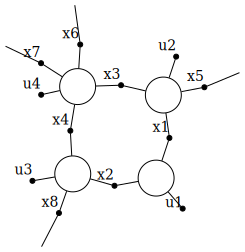

In [457]:
#  u1  x1  u2  x5      x1-x2-
#  x2      x3          |  |
#  u3  x4  u4  x6      x3-x4-
#  x8      x7          |  |

square = @relation (x5,x6,x7,x8) where ( x1::X, x2::X,
                                            x3::X, x4::X,
                                            x5::X, x6::X,
                                            x7::X, x8::X,
                                            u1::X, u2::X, u3::X, u4::X
                                            ) begin
    laplace_corner(x1, x2, u1)
    laplace_edge(x1, x3, x5, u2)
    laplace_edge(x2,x4,x8, u3)
    laplace_bulk(x3,x4,x6,x7, u4)
end;
to_graphviz(square, implicit_junctions=false, port_labels=false, junction_labels=:variable)

## Generating an open square

## Solving the dynamics on the square

In [458]:
p = ODEProblem(f, u₀, (0,10.0), zeros(length(u₀)))
sol = OrdinaryDiffEq.solve(p, Trapezoid());

In [459]:
label=[string(sol.t[i])[1:3] for i in 1:length(sol.u)];

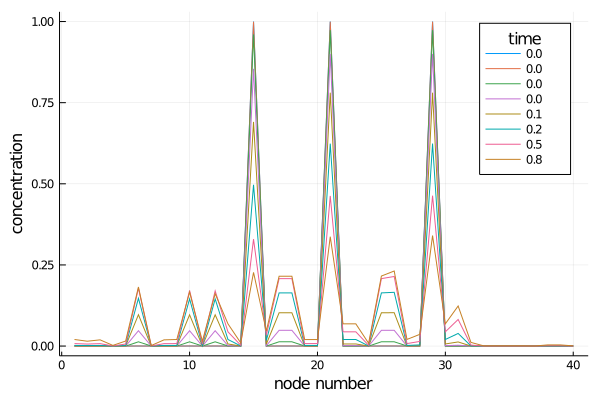

In [460]:
plot(sol.u[1:4:32], label=hcat(label[1:4:32]...), legendtitle="time", xlabel="node number", ylabel="concentration")

┌ Info: Saved animation to 
│   fn = /Users/jfairbanks6/repos/github.com/AlgebraicJulia/AlgebraicDynamics/notebooks/tmp.gif
└ @ Plots /Users/jfairbanks6/.julia/packages/Plots/6RLiv/src/animation.jl:104


Plots.AnimatedGif("/Users/jfairbanks6/repos/github.com/AlgebraicJulia/AlgebraicDynamics/notebooks/tmp.gif")
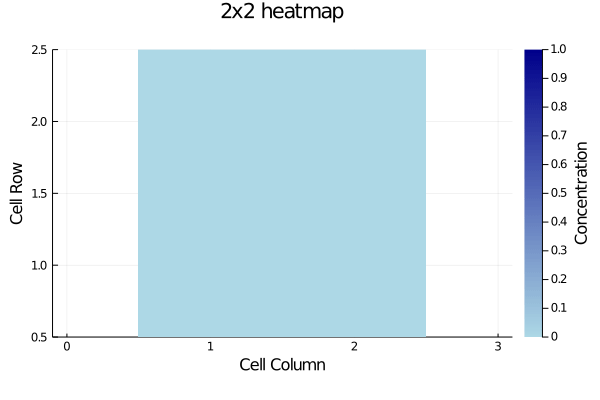

In [461]:
x = 1:2
y = 1:2
timestep = 0.01
solution = sol(0:timestep:2)
anim = @animate for i ∈ 1:length(solution)
    c_func(x::Int, y::Int) = solution[i][(y-1)*2+x]
    heatmap(x,y,c_func, title="2x2 heatmap", aspect_ratio=1,
        clims=(0,maximum(solution[1])), fill=true, color=:blues,
        xaxis="Cell Column", yaxis="Cell Row", colorbartitle="Concentration")
end
gif(anim, fps = 60)

## Compose open squares together

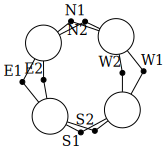

In [473]:
comp_2x2 = @relation () where (N1::X,N2::X,S1::X,S2::X,E1::X,E2::X,W1::X,W2::X) begin
    square(N1,N2,E1,E2)
    # horizontal mirror of square1
    square(N1,N2,W1,W2)
    # vertical mirror of square1
    square(S1,S2,E1,E2)
    # double mirror of square1
    square(S1,S2,W1,W2)
end
to_graphviz(comp_2x2, port_labels=false, junction_labels=:variable)

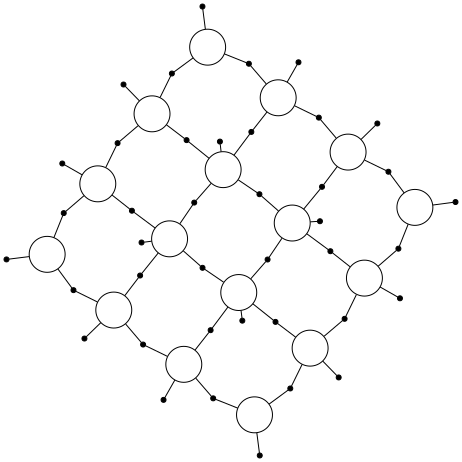

In [474]:
square_4x4 = ocompose(comp_2x2,[square, square, square, square]);
to_graphviz(square_4x4, port_labels=false, junction_labels=nothing)

In [299]:
square_4x4

CSet
  Box = 1:16
  Port = 1:64
  OuterPort = 1:0
  Junction = 1:40
  box : Port → Box
    [1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 16]
  junction : Port → Junction
    [9, 10, 13, 9, 11, 1, 14, 10, 12, 6, 15, 11, 12, 2, 5, 16, 17, 18, 21, 17, 19, 1, 22, 18, 20, 8, 23, 19, 20, 2, 7, 24, 25, 26, 29, 25, 27, 3, 30, 26, 28, 6, 31, 27, 28, 4, 5, 32, 33, 34, 37, 33, 35, 3, 38, 34, 36, 8, 39, 35, 36, 4, 7, 40]
  outer_junction : OuterPort → Junction
    Int64[]
  port_type : Port → Union{Missing, Symbol}
    Union{Missing, Symbol}[:X, :Y, :X, :X, :X, :X, :X, :Y, :X, :X, :X, :X, :X, :X, :X, :X, :X, :Y, :X, :X, :X, :X, :X, :Y, :X, :X, :X, :X, :X, :X, :X, :X, :X, :Y, :X, :X, :X, :X, :X, :Y, :X, :X, :X, :X, :X, :X, :X, :X, :X, :Y, :X, :X, :X, :X, :X, :Y, :X, :X, :X, :X, :X, :X, :X, :X]
  outer_port_type : OuterPort → Unio

## Solve the new system

In [465]:

f = vectorfield(square_4x4,generators)

u₀ = [ 0, 0, 0, 0,
       0, 0, 0, 0,
       0, 0,
       0, 0,
       0, 0, 1, 0,
       0, 0,
       0, 0,
       1, 0, 0, 0,
       0, 0,
       0, 0,
       1, 0, 0, 0,
       0, 0,
       0, 0,
       0, 0, 0, 0]

p = ODEProblem(f, u₀, (0,10.0), zeros(48))

sol = OrdinaryDiffEq.solve(p, Trapezoid());

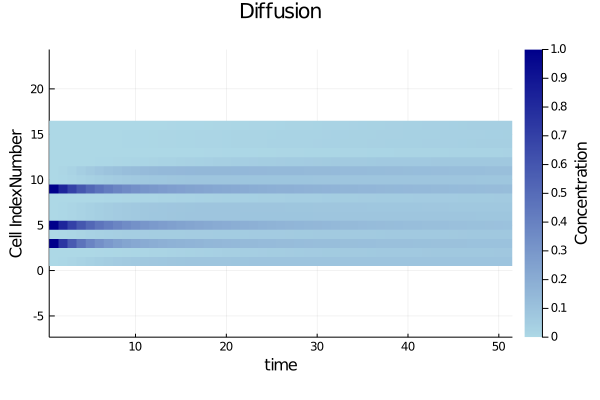

In [466]:
timestep = 0.1
solution = sol(0:timestep:5)
varmap = map(1:nparts(square_4x4, :Box)) do b
    u_port = incident(square_4x4, b, :box)[end]
    subpart(square_4x4, :junction)[u_port]
end

c_func(x::Int, y::Int) = (solution[x][varmap[y]])
y = 1:nparts(square_4x4, :Box)
x = 1:length(solution)
heatmap(x,y,c_func, title="Diffusion", aspect_ratio=1,
        clims=(0,maximum(solution)), fill=true, color=:blues,
        xaxis="time", yaxis="Cell IndexNumber",
        colorbartitle="Concentration")


In [467]:
rvarmap = varmap[[1 2 15 13; 3 4 16 14; 6 8 12 10; 5 7 11 9]]

4×4 Array{Int64,2}:
 13  14  39  37
 15  16  40  38
 22  24  32  30
 21  23  31  29

┌ Info: Saved animation to 
│   fn = /Users/jfairbanks6/repos/github.com/AlgebraicJulia/AlgebraicDynamics/notebooks/tmp.gif
└ @ Plots /Users/jfairbanks6/.julia/packages/Plots/6RLiv/src/animation.jl:104


Plots.AnimatedGif("/Users/jfairbanks6/repos/github.com/AlgebraicJulia/AlgebraicDynamics/notebooks/tmp.gif")
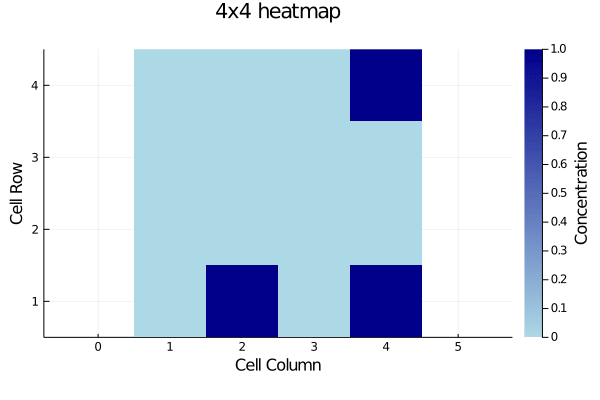

In [468]:
x = 1:4
y = 1:4
timestep = 0.1
solution = sol(0:timestep:5)
anim = @animate for i ∈ 1:length(solution)
    c_func(x::Int, y::Int) = (solution[i][rvarmap[x,y]])
    heatmap(x,y,c_func, title="4x4 heatmap", aspect_ratio=1,
        clims=(0,maximum(solution[1])), fill=true, color=:blues,
        xaxis="Cell Column", yaxis="Cell Row",
        colorbartitle="Concentration")
end
gif(anim, fps = 10)

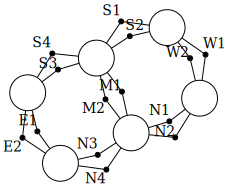

In [469]:
comp_2x2 = @relation () where (N1::X,N2::X,S1::X,S2::X,E1::X,E2::X,W1::X,W2::X, N3::X, N4::X, S3::X, S4::X, M1::X, M2::X) begin
    square_corner(W1,W2,N2,N1)
    square_edge(  N1,N2,M1,M2,N3,N4)
    square_corner(N4,N3,E1,E2)
    square_corner(W1,W2,S2,S1)
    square_edge(  S1,S2,M1, M2, S4,S3)
    square_corner(S3,S4,E1,E2)
end
to_graphviz(comp_2x2, port_labels=false, junction_labels=:variable)


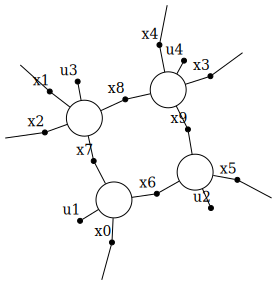

In [470]:
squaremid = @relation (x0,x1,x2,x3,x4,x5) where ( x0::X, x1::X, x2::X,
                                            x3::X, x4::X,
                                            x5::X, x6::X,
                                            x7::X, x8::X,
                                            x9::X,
                                            u1::X, u2::X, u3::X, u4::X
                                            ) begin
    laplace_edge(x0, x7, x6, u1)
    laplace_edge(x6, x9, x5, u2)
    laplace_bulk(x7,x1,x2, x8, u3)
    laplace_bulk(x9,x8,x3,x4, u4)
end;
to_graphviz(squaremid, implicit_junctions=false, port_labels=false, junction_labels=:variable)

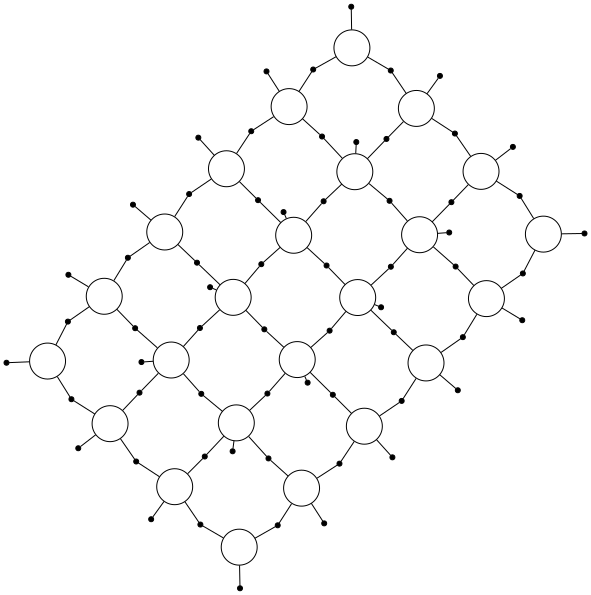

In [471]:
threeby2 = ocompose(comp_2x2, [square, squaremid, square, square, squaremid, square])
to_graphviz(threeby2, port_labels=false)

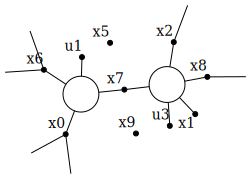

In [451]:
squaremid = @relation (x0,x6,x8,x2,x0,x6) where ( x0::X, x1::X, x2::X,
                                            #x3::X, x4::X,
                                            x5::X, x6::X,
                                            x7::X, x8::X,
                                            x9::X,
                                            u1::X, u3::X
                                            ) begin
    laplace_edge(x0, x7, x6, u1)
    laplace_bulk(x7,x1,x2, x8, u3)
end;
to_graphviz(squaremid, implicit_junctions=false, port_labels=false, junction_labels=:variable)

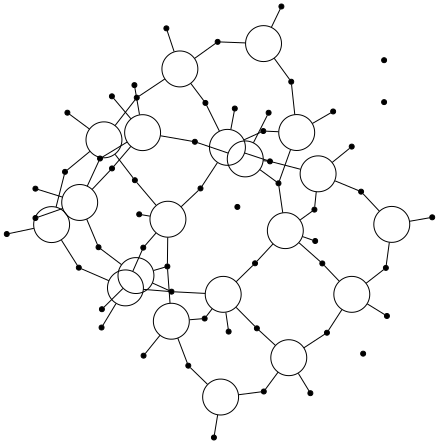

In [452]:
threeby2 = ocompose(comp_2x2, [square, squaremid, square, square, squaremid, square])
to_graphviz(threeby2, port_labels=false)